# Vision transfomers example implementation

#### Learning materials:
[Basic Fine-tuning tutorial](https://huggingface.co/learn/computer-vision-course/unit3/vision-transformers/vision-transformer-for-objection-detection)

[How DETR works on HF](https://huggingface.co/docs/transformers/model_doc/detr)

[DEtection TRansformer (DETR) on HF](https://huggingface.co/learn/computer-vision-course/unit3/vision-transformers/detr)

[Official DETR repo](https://github.com/facebookresearch/detr)




## Prep

In [1]:
%pip install -U -q datasets transformers[torch] evaluate timm albumentations accelerate numba

Note: you may need to restart the kernel to use updated packages.


In [2]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


## Dataset

### Download dataset

In [3]:
from datasets import load_dataset

dataset = load_dataset("anindya64/hardhat")
dataset 

/Users/kamil/Desktop/AI/ComputerVision/laba-cv-project/cv_venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['image', 'image_id', 'width', 'height', 'objects'],
        num_rows: 5297
    })
    test: Dataset({
        features: ['image', 'image_id', 'width', 'height', 'objects'],
        num_rows: 1766
    })
})

In [4]:
dataset["train"][0]


{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375>,
 'image_id': 1,
 'width': 500,
 'height': 375,
 'objects': {'id': [1, 1],
  'area': [3068.0, 690.0],
  'bbox': [[178.0, 84.0, 52.0, 59.0], [111.0, 144.0, 23.0, 30.0]],
  'category': ['helmet', 'helmet']}}

In [5]:
train_dataset = dataset["train"]
test_dataset = dataset["test"]

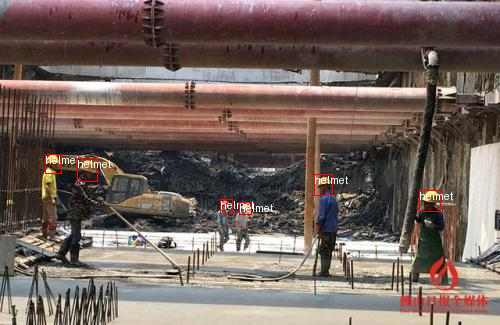

In [6]:
import numpy as np
from PIL import Image, ImageDraw


def draw_image_from_idx(dataset, idx):
    sample = dataset[idx]
    image = sample["image"]
    annotations = sample["objects"]
    draw = ImageDraw.Draw(image)
    width, height = sample["width"], sample["height"]

    for i in range(len(annotations["id"])):
        box = annotations["bbox"][i]
        class_idx = annotations["id"][i]
        x, y, w, h = tuple(box)
        if max(box) > 1.0:
            x1, y1 = int(x), int(y)
            x2, y2 = int(x + w), int(y + h)
        else:
            x1 = int(x * width)
            y1 = int(y * height)
            x2 = int((x + w) * width)
            y2 = int((y + h) * height)
        draw.rectangle((x1, y1, x2, y2), outline="red", width=1)
        draw.text((x1, y1), annotations["category"][i], fill="white")
    return image


import random
random_idx = random.randint(0, len(train_dataset) - 1)
draw_image_from_idx(dataset=train_dataset, idx=random_idx)

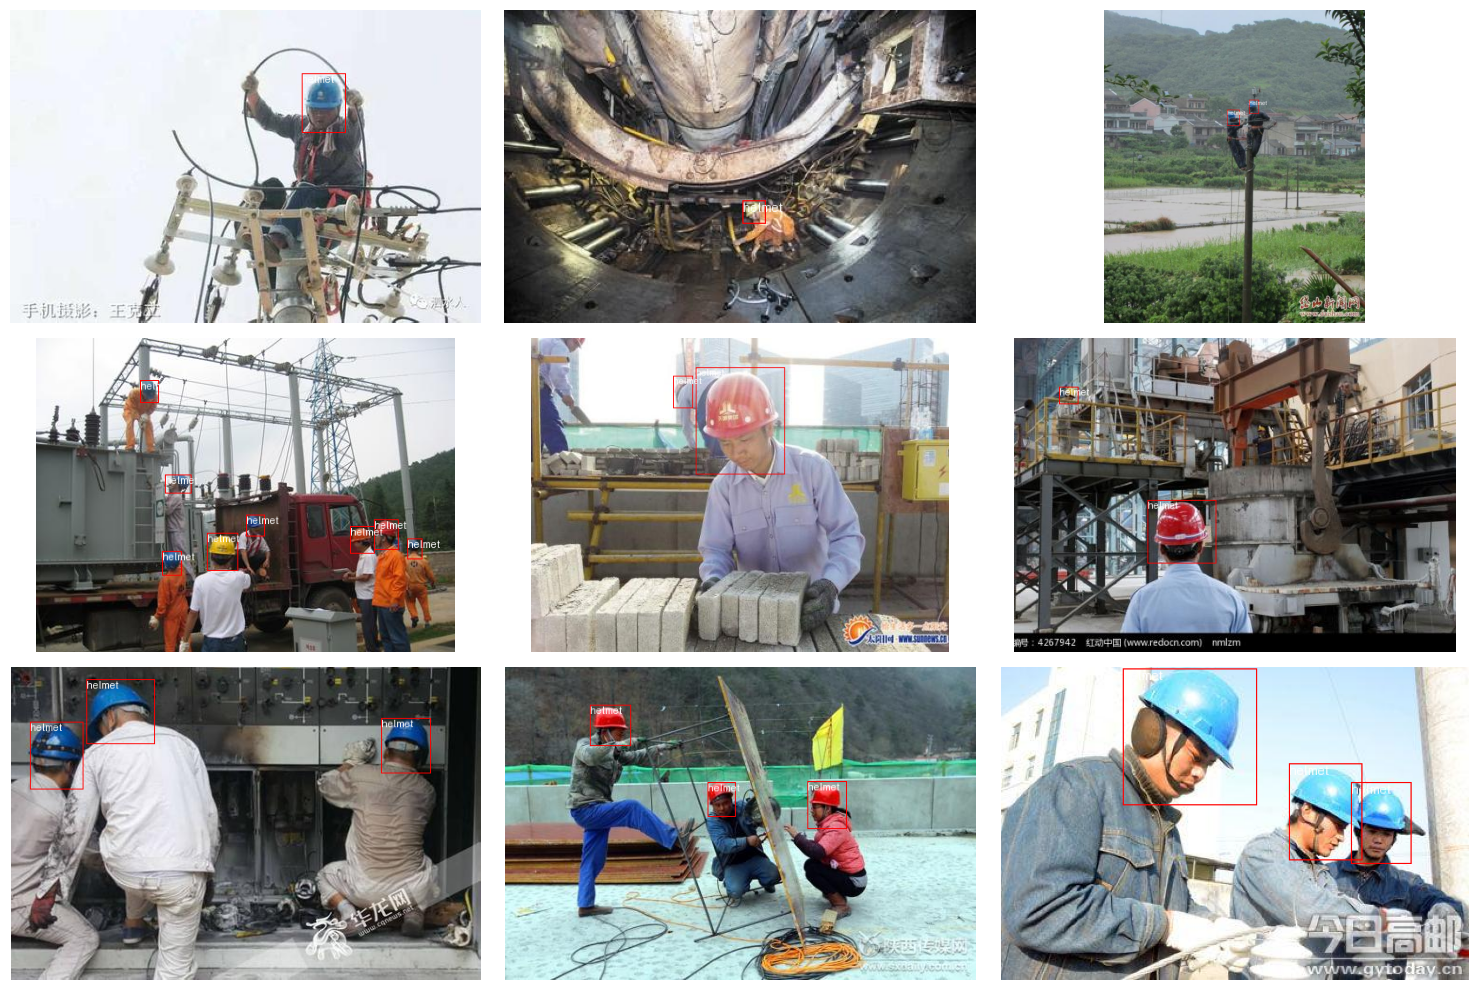

In [7]:
import matplotlib.pyplot as plt


import random

def plot_images(dataset, num_images=9):
    indices = random.sample(range(len(dataset)), num_images)
    num_rows = num_images // 3
    num_cols = 3
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

    for i, idx in enumerate(indices):
        row = i // num_cols
        col = i % num_cols

        # Draw image
        image = draw_image_from_idx(dataset, idx)

        # Display image on the corresponding subplot
        axes[row, col].imshow(image)
        axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()


# Now use the function to plot images
plot_images(train_dataset)


### Preprocessing the Dataset

In [8]:
from transformers import AutoImageProcessor

checkpoint = "facebook/detr-resnet-50-dc5"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [9]:
import albumentations
import numpy as np
import torch

transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

Once we initialize all the transformations, we need to make a function which formats the annotations and returns the a list of annotation with a very specific format.

This is because the image_processor expects the annotations to be in the following format: {'image_id': int, 'annotations': List[Dict]}, where each dictionary is a COCO object annotation.

In [10]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

In [11]:
# transforming a batch

def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["id"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

In [12]:
# Apply transformations for both train and test dataset

train_dataset_transformed = train_dataset.with_transform(transform_aug_ann)
test_dataset_transformed = test_dataset.with_transform(transform_aug_ann)

In [13]:
train_dataset_transformed[0]


{'pixel_values': tensor([[[-0.0801, -0.0801, -0.0801,  ..., -0.2856, -0.4568, -0.5596],
          [-0.0801, -0.0801, -0.0801,  ..., -0.2856, -0.4568, -0.5767],
          [-0.0801, -0.0801, -0.0972,  ..., -0.3027, -0.4739, -0.5938],
          ...,
          [-0.4568, -0.5424, -0.6794,  ..., -0.7308, -0.7993, -0.8335],
          [-0.4568, -0.5596, -0.6965,  ..., -0.7479, -0.8335, -0.8678],
          [-0.4568, -0.5596, -0.6965,  ..., -0.7650, -0.8507, -0.9020]],
 
         [[-0.0224, -0.0224, -0.0224,  ...,  0.1877, -0.0049, -0.1275],
          [-0.0224, -0.0224, -0.0224,  ...,  0.1702, -0.0224, -0.1450],
          [-0.0224, -0.0224, -0.0399,  ...,  0.1527, -0.0399, -0.1800],
          ...,
          [-0.0049, -0.1099, -0.2675,  ..., -0.4251, -0.4951, -0.5301],
          [-0.0049, -0.1099, -0.2850,  ..., -0.4426, -0.5301, -0.5651],
          [-0.0049, -0.1099, -0.2850,  ..., -0.4601, -0.5476, -0.6001]],
 
         [[ 0.2871,  0.2871,  0.2871,  ...,  0.8622,  0.6705,  0.5485],
          [ 

A collate_fn is responsible for taking a list of samples from a dataset and converting them into a batch suitable for model’s input format.

In general a DataCollator typically performs tasks such as padding, truncating etc. In a custom collate function, we often define what and how we want to group the data into batches or simply, how to represent each batch.

Data collator mainly puts the data together and then preprocesses them. Let’s make our collate function.

In [14]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

## Training

In [15]:
from huggingface_hub import login
try:
    from google.colab import userdata
    login(token=userdata.get('HF_TOKEN'))
except ImportError:
    login()

In [16]:
from transformers import AutoModelForObjectDetection

id2label = {0: "head", 1: "helmet", 2: "person"}
label2id = {v: k for k, v in id2label.items()}


model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of the model checkpoint at facebook/detr-resnet-50-dc5 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model check

In [ ]:
from transformers import TrainingArguments
from transformers import Trainer

# Define the training arguments

training_args = TrainingArguments(
    output_dir="detr-resnet-50-hardhat-finetuned",
    per_device_train_batch_size=8,
    num_train_epochs=5,
    fp16=True,
    logging_steps=100,
    learning_rate=1e-4,
    weight_decay=1e-4,
    warmup_steps=100,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=True,
)

# Define the trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=train_dataset_transformed,
    eval_dataset=test_dataset_transformed,
    tokenizer=image_processor,
)

trainer.train()


## Testing


If you save the model to the hub, you need to change the model to your own username and the name of the model.

In [22]:
import requests
from transformers import pipeline

# make the object detection pipeline

model = 'theButcher22/detr-resnet-50-hardhat-finetuned'
#model = 'facebook/detr-resnet-50-dc5' # original model
#model = 'anindya64/detr-resnet-50-dc5-hardhat-finetuned' #banchmark model

obj_detector = pipeline(
    "object-detection", 
    model= model, 
    threshold=0.3
)
results = obj_detector(train_dataset[0]["image"])

print(results)

Device set to use mps:0


[{'score': 0.9647936820983887, 'label': 'helmet', 'box': {'xmin': 104, 'ymin': 146, 'xmax': 133, 'ymax': 172}}, {'score': 0.9961095452308655, 'label': 'helmet', 'box': {'xmin': 174, 'ymin': 85, 'xmax': 229, 'ymax': 142}}]


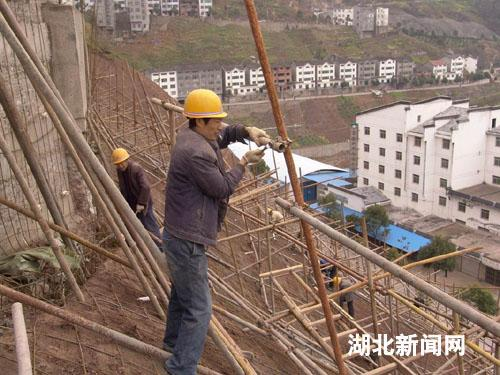

In [18]:
image = train_dataset[0]["image"]
image

In [23]:
from PIL import ImageFont

def plot_results(image, results, threshold=0.7):
    image = Image.fromarray(np.uint8(image))
    draw = ImageDraw.Draw(image)
    for result in results:
        score = result["score"]
        label = result["label"]
        box = list(result["box"].values())
        if score > threshold:
            x, y, x2, y2 = tuple(box)
            draw.rectangle((x, y, x2, y2), outline="red", width=1)
            draw.text(
                (x + 0.5, y - 0.5),
                text=str(label),
                fill="green" if score > 0.7 else "red",
                font=ImageFont.load_default(size=16) # Increased font size
            )
    return image

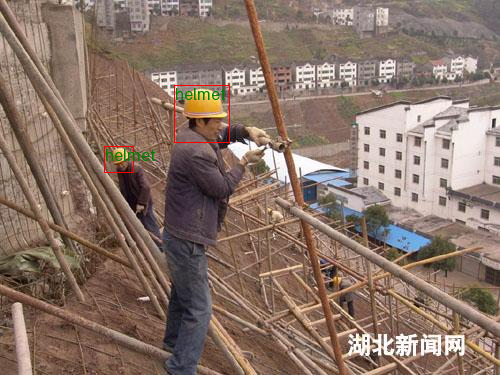

In [24]:
plot_results(image, results, threshold=0.5)


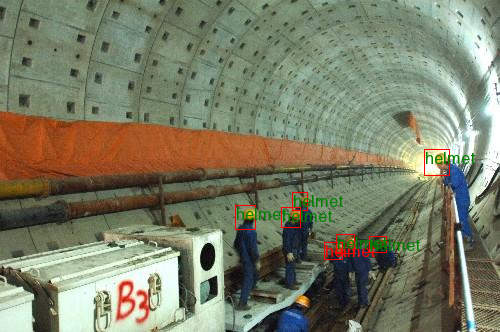

In [25]:
def predict(image, pipeline, threshold=0.1):
    results = pipeline(image)
    return plot_results(image, results, threshold)


# Let's test for another test image

img = test_dataset[0]["image"]
predict(img, obj_detector)

  0%|          | 0/6 [00:00<?, ?it/s]

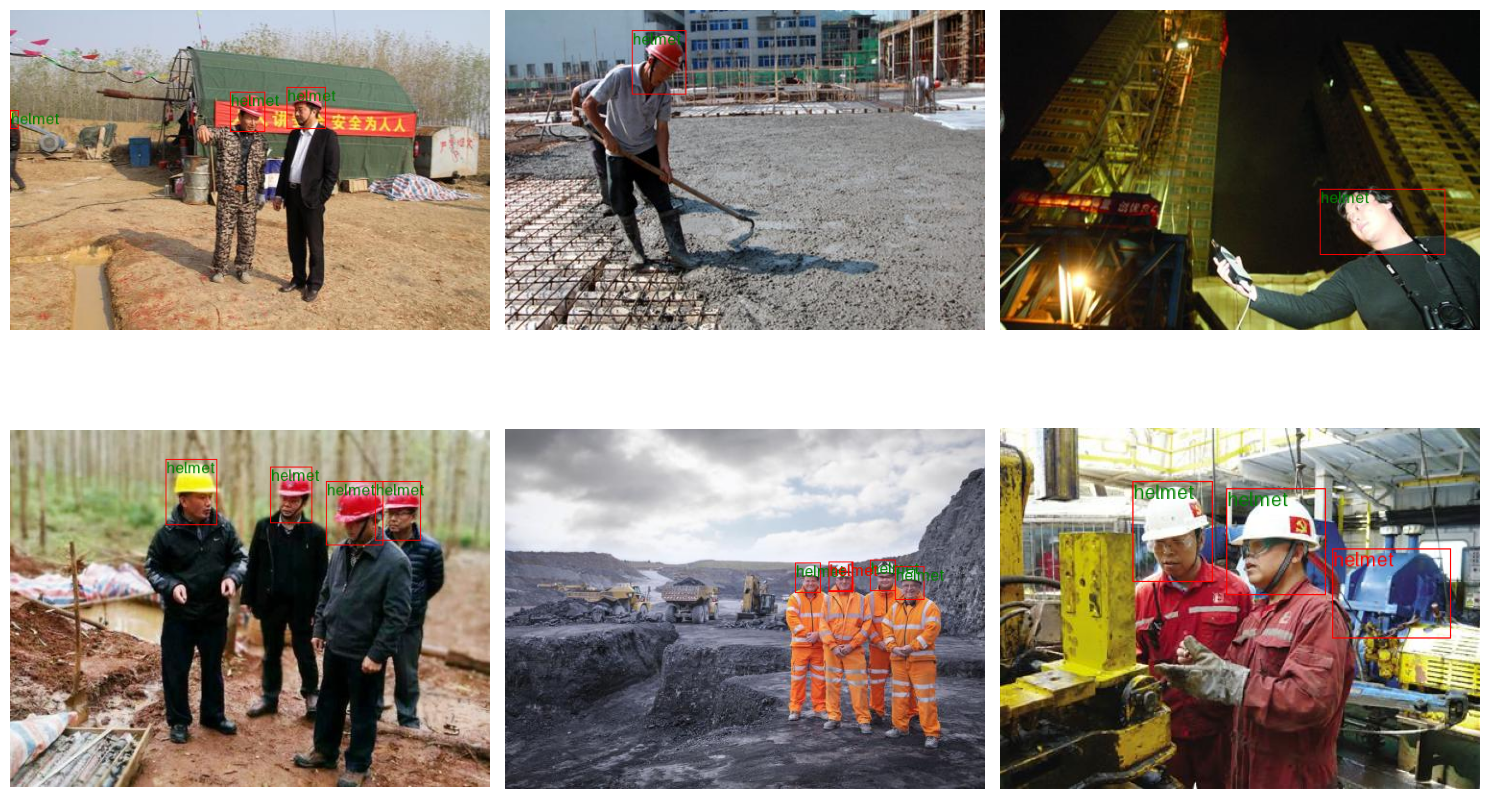

In [28]:
from tqdm.auto import tqdm


def plot_images(dataset, indices):
    """
    Plot images and their annotations.
    """
    indices = random.sample(range(len(dataset)), len(indices))
    num_rows = len(indices) // 3
    num_cols = 3
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))


    for i, idx in tqdm(enumerate(indices), total=len(indices)):
        row = i // num_cols
        col = i % num_cols

        # Draw image
        image = predict(dataset[idx]["image"], obj_detector)

        # Display image on the corresponding subplot
        axes[row, col].imshow(image)
        axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()


plot_images(test_dataset, range(6))